# Mineria de Datos - Grado en Estadistica y Empresa

# Practica 2 - Andrés Rubio Lafuente



## Paquetes y Funciones

Cargamos los paquetes necesarios y definimos las funciones necesarias para realizar la practica.

In [ ]:
# Paquetes para el webscraping
import bs4
from bs4 import BeautifulSoup
import requests
import csv

# Paquetes basicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paquetes para el arbol de regresion
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

# Paquetes para el clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.stats import t

# Creamos una funcion para realizar el web scraping
# La funcion accede a los atributos precio, nombre de la casa, superficie, numero de habitaciones y baños y planta.
def webscraping(url, inicio, final):
  caracteristicas = []
  for num_pag in range(inicio, final + 1):
       sig_pag = url + str(num_pag)
       respuesta = requests.get(str(sig_pag))
       soup = BeautifulSoup(respuesta.content, "html.parser")
       ad_secciones = soup.find_all('div', {'class': 'ad-preview__bottom'})

       for ad_seccion in ad_secciones:
            info_seccion = ad_seccion.find('div', {'class': 'ad-preview__info'})
            precio  = info_seccion.find('span', {'class': 'ad-preview__price'})
            nombre = info_seccion.find('a', {'class': 'ad-preview__title'})
            direccion = info_seccion.find('p', {'class': 'p-sm'})
            car_seccion = info_seccion.find_all('div', {'class': 'ad-preview__section'})[2]
            car_elementos = car_seccion.find_all('p', {'class': 'ad-preview__char p-sm'})
            car_dicc = {key: 'N/A' for key in ['Habitaciones', 'Baños', 'Area', 'Planta']}

            for car in car_elementos:
               car_texto = car.text.strip()
               if 'hab' in car_texto:
                 car_dicc['Habitaciones'] = car_texto
               elif 'baño' in car_texto:
                 car_dicc['Baños'] = car_texto
               elif 'm²' in car_texto:
                 car_dicc['Area'] = car_texto
               elif 'planta' in car_texto or 'bajo' in car_texto.lower():
                 car_dicc['Planta'] = car_texto

            datos = {'Nombre': nombre.text.strip(),
                     'Barrio': direccion.text.strip(),
                      **car_dicc,
                     'Precio': precio.text.strip()}
            caracteristicas.append(datos)

  df = pd.DataFrame(caracteristicas)
  return(df)

# Creamos una funcion para dibujar el dendrograma
def dendrograma(model, **kwargs):
    plt.figure(figsize = (20,7))
    cont = np.zeros(model.children_.shape[0])
    n = len(model.labels_)
    for i, j in enumerate(model.children_):
        cont1 = 0
        for idx in j:
            if idx < n:
                cont += 1
            else:
                cont1 += cont[idx - n]
        cont[i] = cont1
    linkage_matrix = np.column_stack([model.children_, model.distances_, cont]).astype(float)
    _ = dendrogram(linkage_matrix, **kwargs)

# Creamos una funcion para la silueta media
def silueta():
  silueta_media = []
  rango = range(2, 11)
  for k in rango:
    cluster = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward', n_clusters = k)
    labels = cluster.fit_predict(X)
    s_media = silhouette_score(X, labels)
    silueta_media.append(s_media)

  plt.figure(figsize = (12,5))
  plt.plot(rango, silueta_media, marker = 'o')
  plt.xlabel("K")
  plt.ylabel("Silueta media")
  plt.title("Silueta media para numero de clusters optimo")
  plt.show()

## Web Scraping

Seleccionamos la pagina de la que queremos extraer informacion y solicitamos extraer la informacion.

In [ ]:
pisos_url = 'https://www.pisos.com/venta/pisos-madrid_capital_zona_urbana/fecharecientedesde-desc/'
pisos_response = requests.get(pisos_url)
pisos_response

<Response [200]>

La respuesta a la solicitud es 200, lo que nos indica que nuestra solicitud ha sido aceptada y podemos realizar web scraping.

In [ ]:
pisos = BeautifulSoup(pisos_response.text, 'html.parser')

Llamamos a la funcion y buscamos las primeras 30 paginas.

In [ ]:
pisos_info = webscraping(pisos_url, 0, 29)
pisos_info[:3]

,Nombre,Barrio,Habitaciones,Baños,Area,Planta,Precio
0,"Dúplex en calle Nanclares de Oca, 1",Rejas (Distrito San Blas. Madrid Capital),1 hab.,1 baño,117 m²,Bajo,170.000 €
1,Piso en Avenida de Nuestra Señora de Valvanera,Vista Alegre (Distrito Carabanchel. Madrid Cap...,3 habs.,1 baño,70 m²,Bajo,150.000 €
2,Piso en calle de la Paz,Sol (Distrito Centro. Madrid Capital),2 habs.,2 baños,104 m²,N/A,749.000 €


Carga y limpieza de datos:
1. Extraemos el distrito donde esta la casa que sera nuestra columna barrio.
2. Eliminamos la columna nombre de la casa, no nos proporciona ninguna informacion adicional pues ya tenemos el barrio.
3. Cambiamos la columna habitaciones, baños, area y planta para que solo se quede con el dato numerico. En el caso de los NA o valores distintos a numericos en el caso de la Planta, por ejemplo la planta Bajo, ponemos 0.
4. Eliminamos el caracter euro de la columna precio.  



In [ ]:
datos = pisos_info
datos['Barrio'] = datos['Barrio'].str.extract(r'Distrito (\w+(?:\s\w+)*)')
codigo_barrio = pd.factorize(datos['Barrio'])[0]
info_barrio = pd.DataFrame({'Barrio': datos['Barrio'], 'CODIGO_BARRIO': codigo_barrio})
info_barrio = info_barrio.drop_duplicates(subset = ['Barrio'])
print(info_barrio)

datos = datos.drop(['Nombre'], axis = 1)
datos['Barrio'] = pd.factorize(datos['Barrio'])[0]
datos['Precio'] = datos['Precio'].replace('A consultar', '0')
datos['Precio'] = datos['Precio'].str.replace('€', '').str.replace('.','').astype(int)
datos['Habitaciones'] = datos['Habitaciones'].replace('N/A', '0')
datos['Habitaciones'] = datos['Habitaciones'].str.replace('hab.', '').str.replace('.','').astype(int)
datos['Baños'] = datos['Baños'].str.extract('(\d+)')
datos['Area'] = datos['Area'].str.replace('m.','')
datos['Planta'] = datos['Planta'].str.extract('(\d+)')
datos = datos.fillna(0)
datos = datos.drop_duplicates()
datos[:7]

                 Barrio  CODIGO_BARRIO
0              San Blas              0
1           Carabanchel              1
2                Centro              2
4             Salamanca              3
8             Hortaleza              4
9            Fuencarral              5
10              Moncloa              6
11               Tetuán              7
12   Puente de Vallecas              8
13               Retiro              9
16               Latina             10
18    Villa de Vallecas             11
26        Ciudad Lineal             12
65             Chamberí             13
70            Moratalaz             14
73                Usera             15
75           Villaverde             16
82            Chamartín             17
88           Arganzuela             18
173           Vicálvaro             19
218             Barajas             20


<ipython-input-141-be907ecb99c7>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  datos['Precio'] = datos['Precio'].str.replace('€', '').str.replace('.','').astype(int)
<ipython-input-141-be907ecb99c7>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  datos['Habitaciones'] = datos['Habitaciones'].str.replace('hab.', '').str.replace('.','').astype(int)
<ipython-input-141-be907ecb99c7>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  datos['Habitaciones'] = datos['Habitaciones'].str.replace('hab.', '').str.replace('.','').astype(int)
<ipython-input-141-be907ecb99c7>:15: FutureWarning: The default value of regex will change fro

,Barrio,Habitaciones,Baños,Area,Planta,Precio
0,0,1,1,117,0,170000
1,1,3,1,70,0,150000
2,2,2,2,104,0,749000
3,2,3,3,125,0,999000
4,3,2,2,59,0,649000
5,2,3,3,111,0,849000
6,2,4,4,164,0,1189000


Guardamos los datos en un csv.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datos.to_csv('/content/drive/MyDrive/Mineria de Datos/Practica Grupal/datos_casas.csv', index = False)

## Limpieza de Datos

Importamos los datos con los que vamos a trabajar.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Aqui tenemos la lista de barrios asi como el codigo que se ha asignado en el web scraping.

In [ ]:
codigo_barrio = list(range(21))
nombre_barrio = ['San Blas','Carabanchel','Centro','Salamanca',
                 'Hortaleza', 'Fuencarral', 'Moncloa', 'Tetuán',
                 'Puente de Vallecas', 'Retiro', 'Latina', 'Villa de Vallecas',
                 'Ciudad Lineal', 'Chamberí', 'Moratalaz', 'Usera', 'Villaverde',
                 'Chamartín', 'Arganzuela', 'Vicálvaro', 'Barajas']
info_barrio = pd.DataFrame({'Codigo': codigo_barrio, 'Nombre': nombre_barrio})
print(info_barrio)

    Codigo              Nombre
0        0            San Blas
1        1         Carabanchel
2        2              Centro
3        3           Salamanca
4        4           Hortaleza
5        5          Fuencarral
6        6             Moncloa
7        7              Tetuán
8        8  Puente de Vallecas
9        9              Retiro
10      10              Latina
11      11   Villa de Vallecas
12      12       Ciudad Lineal
13      13            Chamberí
14      14           Moratalaz
15      15               Usera
16      16          Villaverde
17      17           Chamartín
18      18          Arganzuela
19      19           Vicálvaro
20      20             Barajas


Como vemos los codigos de los barrios no tienen ningun orden especifico, con lo cual es como si fuese una columna identificadora que no proporciona informacion ninguna. Ya veremos que hacemos con esta columna.

Cargamos los datos, que los habiamos guardado en un archivo csv tras finalizar el web scraping.

In [ ]:
datos = pd.read_csv('/content/drive/MyDrive/Mineria de Datos/Practica Grupal/datos_casas.csv')
datos[:3]

,Barrio,Habitaciones,Baños,Area,Planta,Precio
0,0,1,1,117.0,0,170000
1,1,3,1,70.0,0,150000
2,2,2,2,104.0,0,749000


Antes de nada, vamos a ordenar los barrios para que sean de mas utilidad que una columna identificadora.

Tenemos 21 barrios, ordenados sin un orden especifico del 0 al 21.

Pues bien, nosotros los queremos ordenar de forma que el barrio 0 sea el mas caro y el barrio 21 sea el mas barato.

Para ello, agrupamos las casa por barrio, calculamos el precio medio por vivienda y ordenamos los barrios de mas caro a mas barato.

In [ ]:
precio_barrio = datos.groupby(['Barrio'])['Precio'].mean().astype(int)
i_barrio = np.argsort(precio_barrio)[::-1]
ord_barrio = precio_barrio.index[i_barrio]
media_barrio = pd.DataFrame({'Barrio': ord_barrio, 'Precio': precio_barrio.values[i_barrio]})
media_barrio[:5]

,Barrio,Precio
0,3,1232576
1,17,1216684
2,13,1055434
3,9,1004540
4,6,771292


Creamos un diccionario que nos diga la nueva asignacion de codigos para cada barrio.

In [ ]:
dic_barrio = {barrio: codigo for codigo, barrio in enumerate(ord_barrio)}
dic_barrio

{3: 0,
 17: 1,
 13: 2,
 9: 3,
 6: 4,
 2: 5,
 4: 6,
 5: 7,
 7: 8,
 20: 9,
 12: 10,
 18: 11,
 14: 12,
 0: 13,
 11: 14,
 19: 15,
 10: 16,
 1: 17,
 15: 18,
 8: 19,
 16: 20}

El nuevo orden de los barrios de mas caro a mas barato es el siguiente.

In [ ]:
info_barrio['Nuevo_Codigo'] = info_barrio['Codigo'].map(dic_barrio)
info_barrio.drop('Codigo', axis = 1, inplace = True)
info_barrio = info_barrio.sort_values(by = 'Nuevo_Codigo', ascending = True)
print(info_barrio)

                Nombre  Nuevo_Codigo
3            Salamanca             0
17           Chamartín             1
13            Chamberí             2
9               Retiro             3
6              Moncloa             4
2               Centro             5
4            Hortaleza             6
5           Fuencarral             7
7               Tetuán             8
20             Barajas             9
12       Ciudad Lineal            10
18          Arganzuela            11
14           Moratalaz            12
0             San Blas            13
11   Villa de Vallecas            14
19           Vicálvaro            15
10              Latina            16
1          Carabanchel            17
15               Usera            18
8   Puente de Vallecas            19
16          Villaverde            20


Aplicamos este diccionario para transformar los datos.

In [ ]:
datos['Barrio'] = datos['Barrio'].map(dic_barrio)
datos[:3]

,Barrio,Habitaciones,Baños,Area,Planta,Precio
0,13,1,1,117.0,0,170000
1,17,3,1,70.0,0,150000
2,5,2,2,104.0,0,749000


Una vez limpiados los datos, podemos pasar a realizar un EDA basico de los datos.

## EDA

Vemos las dimensiones de los datos con los que estamos trabajando.

In [ ]:
datos.shape

(863, 6)

Tenemos 863 instancias, en este caso, casas, sobre las que se han medido 6 caracteristicas.

Vemos el tipo de datos con los que estamos trabajando.

In [ ]:
datos.dtypes

Barrio            int64
Habitaciones      int64
Baños             int64
Area            float64
Planta            int64
Precio            int64
dtype: object

Tenemos que todas las variables son numericas.

Hacemos un resumen basico de los datos.

In [ ]:
datos.describe()

,Barrio,Habitaciones,Baños,Area,Planta,Precio
count,863.000000,863.000000,863.000000,860.000000,863.000000,8.630000e+02
mean,8.637312,2.505214,1.707995,108.512791,1.500579,5.934902e+05
std,6.207125,1.224142,1.063208,74.776974,2.232368,7.234690e+05
min,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000e+00
25%,4.000000,2.000000,1.000000,64.000000,0.000000,1.990000e+05
50%,7.000000,3.000000,2.000000,89.500000,0.000000,3.297500e+05
75%,14.000000,3.000000,2.000000,125.000000,2.000000,7.490000e+05
max,20.000000,8.000000,7.000000,624.000000,15.000000,5.900000e+06


Vemos que los valores de las variables varian bastante en escala de columna a columna, luego sera necesario escalar los datos

Vemos si hay valores faltantes.

In [ ]:
suma_na = datos.isna().sum()
porcentaje_na = 100 * (suma_na/datos.shape[0])
df_na = pd.DataFrame({'Numero NA':suma_na, 'Porcentaje NA': porcentaje_na})
df_na

,Numero NA,Porcentaje NA
Barrio,0,0.000000
Habitaciones,0,0.000000
Baños,0,0.000000
Area,3,0.347625
Planta,0,0.000000
Precio,0,0.000000


Eliminamos dichas instancias en las que no viene la superficie de la casa.

In [ ]:
datos = datos.dropna(subset = ['Area'])

Comprobamos que se han eliminado los valores faltantes.

In [ ]:
suma_na = datos.isna().sum()
porcentaje_na = 100 * (suma_na/datos.shape[0])
df_na = pd.DataFrame({'Numero NA':suma_na, 'Porcentaje NA': porcentaje_na})
df_na

,Numero NA,Porcentaje NA
Barrio,0,0.0
Habitaciones,0,0.0
Baños,0,0.0
Area,0,0.0
Planta,0,0.0
Precio,0,0.0


Realizamos un histograma de todas las caracteristicas de las casas.

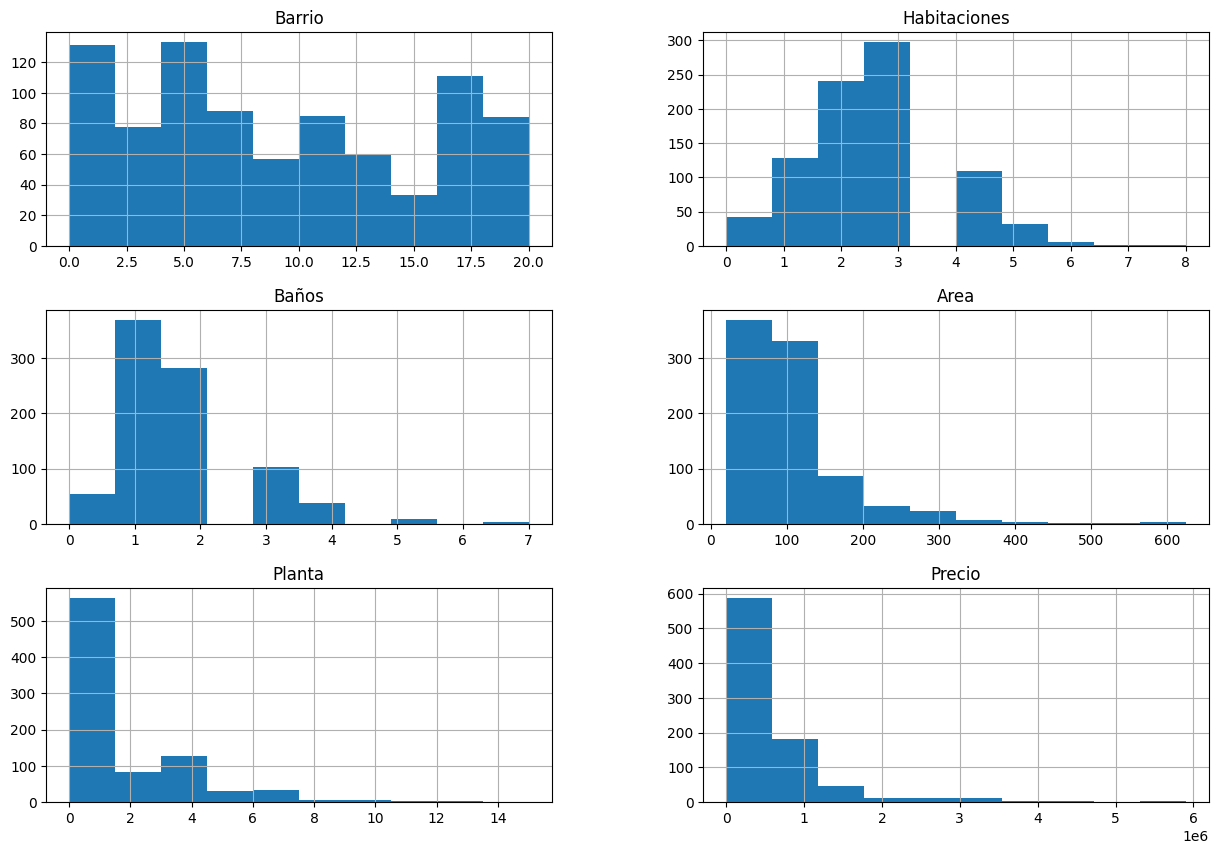

In [ ]:
datos.hist(figsize = (15, 10))
plt.show()

Realizamos un boxplot de la variable respuesta Precio.

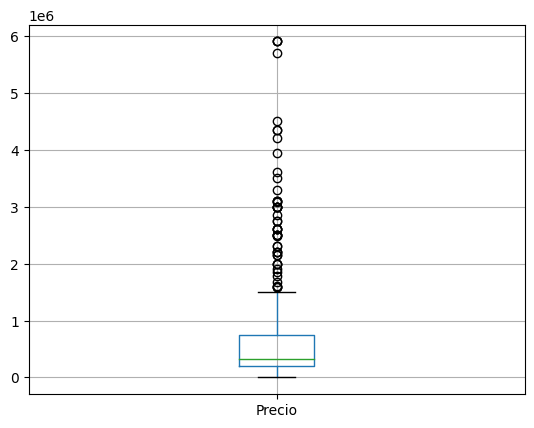

In [ ]:
datos.boxplot(['Precio'])
plt.show()

Como vemos hay algunos valores atipicos, pero si aumentamos el rango intercuartilico practicamente no tenemos valores atipicos.

Obtenemos una matriz de correlaciones para ver las relaciones entre las variables.

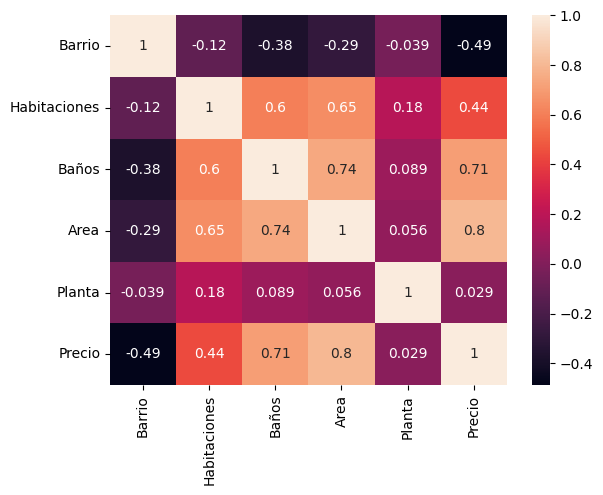

In [ ]:
mcorr = datos.corr()
sns.heatmap(mcorr, annot = True)
plt.show()

Como vemos la mayoria de variables tienen una correlacion baja; sin embargo, hay algunas variables que estan bastante correladas, como son:

1. El numero de habitaciones con el numero de baños.
2. El numero de habitaciones con el area de la casa.
3. El numero de baños con el area de la casa.
4. Todas las variabales a excepcion de la planta estan relacionadas con el precio de la casa. Segun esto, el precio de la casa aumenta si aumenta el numero de baños, de habitaciones, el area y si disminuye el barrio, nos vamos a barrios mas caros.

A pesar de todas estas relaciones, no encontramos 2 variables que esten extremadamente correladas, luego no tenemos que considerar la eliminacion de ninguna variable. Como mucho, podriamos considerar eliminar la variable 'Planta', pues no parece que este muy relacionada con el resto de variables, pero nosotros hemos decidido mantenerla.

Vemos ahora si hay variables con atributos constantes.

In [ ]:
datos.columns[datos.nunique() == 1]

Index([], dtype='object')

No encontramos ninguna variable con atributos constantes; es decir, todas las variables contienen informacion mas o menos util para el modelo.

Por ultimo, podemos ver los precios medios de las casas segun el barrio en el que estemos.

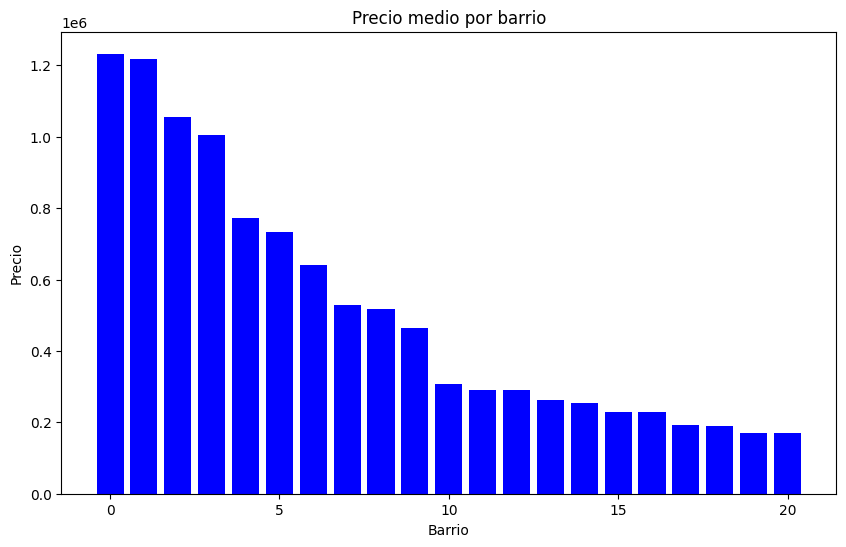

In [ ]:
plt.figure(figsize = (10,6))
plt.bar(info_barrio['Nuevo_Codigo'], media_barrio['Precio'], color = 'blue')
plt.xlabel('Barrio')
plt.ylabel('Precio')
plt.title('Precio medio por barrio')
plt.show()

## Modelo Arbol de Regresion

Dividimos los datos en las variables regresoras X y la variable respuesta Y.

In [ ]:
X = datos.drop(['Precio'], axis = 1)
y = datos['Precio']

Escalamos los datos

In [ ]:
scaler = StandardScaler()
X_trans = scaler.fit_transform(X)

Dividimos los datos en entrenamiento y test utilizando un metodo holdout al 25%; es decir, dedicamos 3/4 de los datos a entrenamiento y un 1/4 a test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = (1/4), random_state = 129)

Ajustamos los hiperparametros del modelo del arbol de regresion, que son la maxima profundidad del arbol y el numero minimo de instancias necesarias para dividir el arbol.

Como metrica de evaluacion del modelo, hemos decidido utilizar el R2, que nos indica el porcentaje de la variabilidad de la variable respuesta que podemos explicar con nuestro modelo.

Por tanto, nuestro objetivo sera maximizar el valor de R2, que esta comprendido entre 0 y 1, donde 1 es que explicamos perfectamente la variabilidad de la variable respuesta.  

In [ ]:
arbol = DecisionTreeRegressor(random_state = 129)
param_grid = {'max_depth': range(3,7),
              'min_samples_split': range(10,20)}
grid_search = GridSearchCV(arbol, param_grid, cv = 10, scoring = 'r2')

Entrenamos el modelo con los datos de entrenamiento.

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=129),
             param_grid={'max_depth': range(3, 7),
                         'min_samples_split': range(10, 20)},
             scoring='r2')

Obtenemos los mejores valores de los hiperparametros.

In [ ]:
grid_search.best_params_

{'max_depth': 6, 'min_samples_split': 12}

Obtenemos el mejor modelo con dichos hiperparametros.

In [ ]:
mejor_arbol = grid_search.best_estimator_

Obtenemos el score del modelo, que es el score de entrenamiento.

In [ ]:
r2_train = grid_search.best_score_
print(f'Entrenamiento r2 = {r2_train}')

Entrenamiento r2 = 0.7238680685683021


Calculamos las predicciones con los datos de test y calculamos el valor R2 de los datos de test.

In [ ]:
y_test_pred = mejor_arbol.predict(X_test).astype(int)
r2_test = r2_score(y_test, y_test_pred)
print(f'Test r2 = {r2_test}')

Test r2 = 0.7428802208591541


Obtenemos un mejor valor de r2 para los datos de test que para los datos de entrenamiento, luego el modelo generaliza muy bien y no se sobreajusta a los datos de entrenamiento.

Obtenemos un R2 = 0.7488, luego con el modelo de arbol de regresion somos capaces de explicar aproximadamente un 75% de la variabilidad de la variable respuesta, lo cual es un resultado bastante decente.

Por ultimo, mostramos las predicciones de los datos de test frente a los valores reales.

In [ ]:
pred_test = pd.DataFrame({'Valor Real': y_test, 'Valor Predicho': y_test_pred})
pred_test[:5]

,Valor Real,Valor Predicho
575,2200000,2608999
547,435000,502678
305,189000,141737
608,410000,591628
754,239000,195802


Observamos que entre los valores reales y los predichos hay una ligera diferencia que hace referencia a ese 25% restante de la variabilidad que no podemos explicar con el modelo.

## Modelo Clustering Dendrograma

Aunque ya sabemos como se agrupan las instancias de nuestro dataframe, que son casas y se agrupan por barrios, vamos a considerar una nueva agrupacion de las casas, pues tenemos demasiados barrios y queremos reducir el numero de grupos.

Para ello, creamos un modelo de clustering para agrupar las instancias por grupos lo mas homogeneo posible dentro de cada grupo y lo mas heterogeneo posible entre los grupos.  

Definimos el modelo de clustering en el que utilizamos la distancia euclidea y se utiliza el criterio de Ward que minimiza la varianza dentro de cada grupo.

In [ ]:
modelo_cluster = AgglomerativeClustering(n_clusters = None, affinity = 'euclidean', linkage = 'ward', distance_threshold = 0)
modelo_cluster.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

Hacemos un dendrograma del modelo de clustering que acabamos de definir.

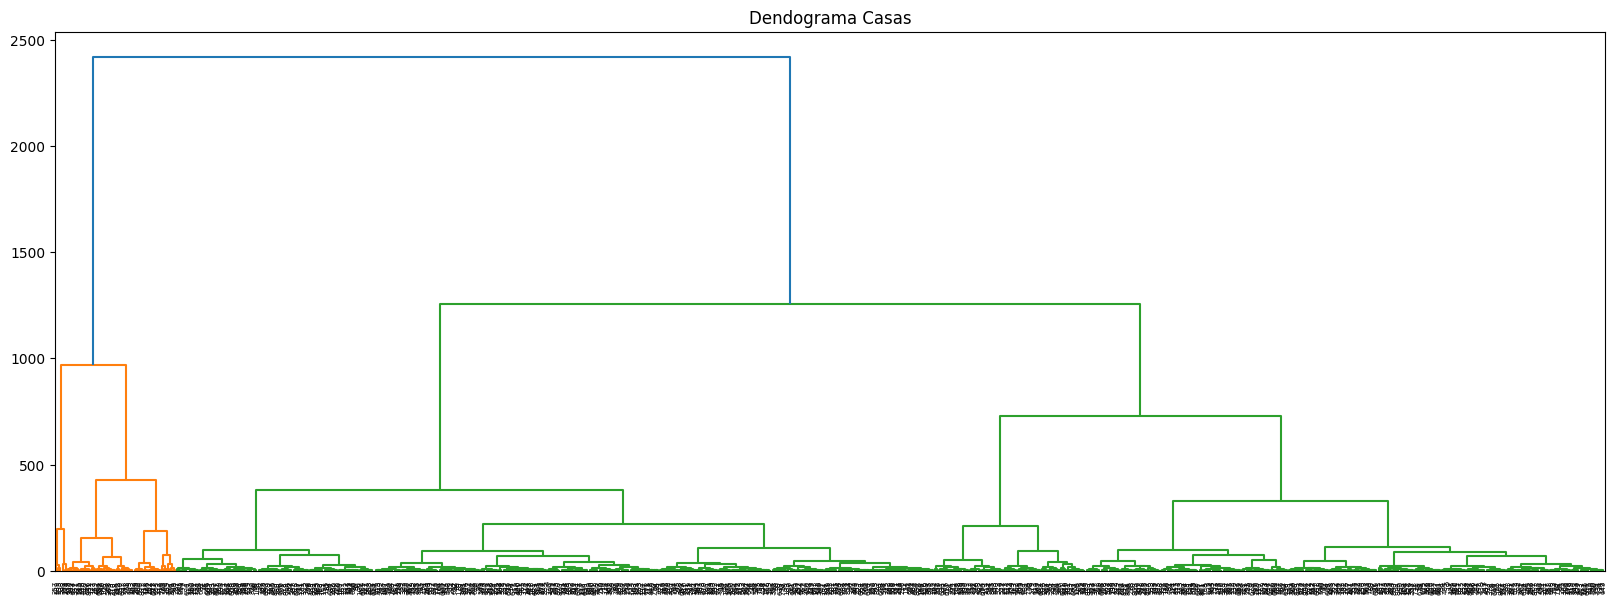

In [ ]:
dendrograma(modelo_cluster, truncate_mode = 'level')
plt.title("Dendograma Casas")
plt.show()

Marcamos el punto de corte para el dendrograma.

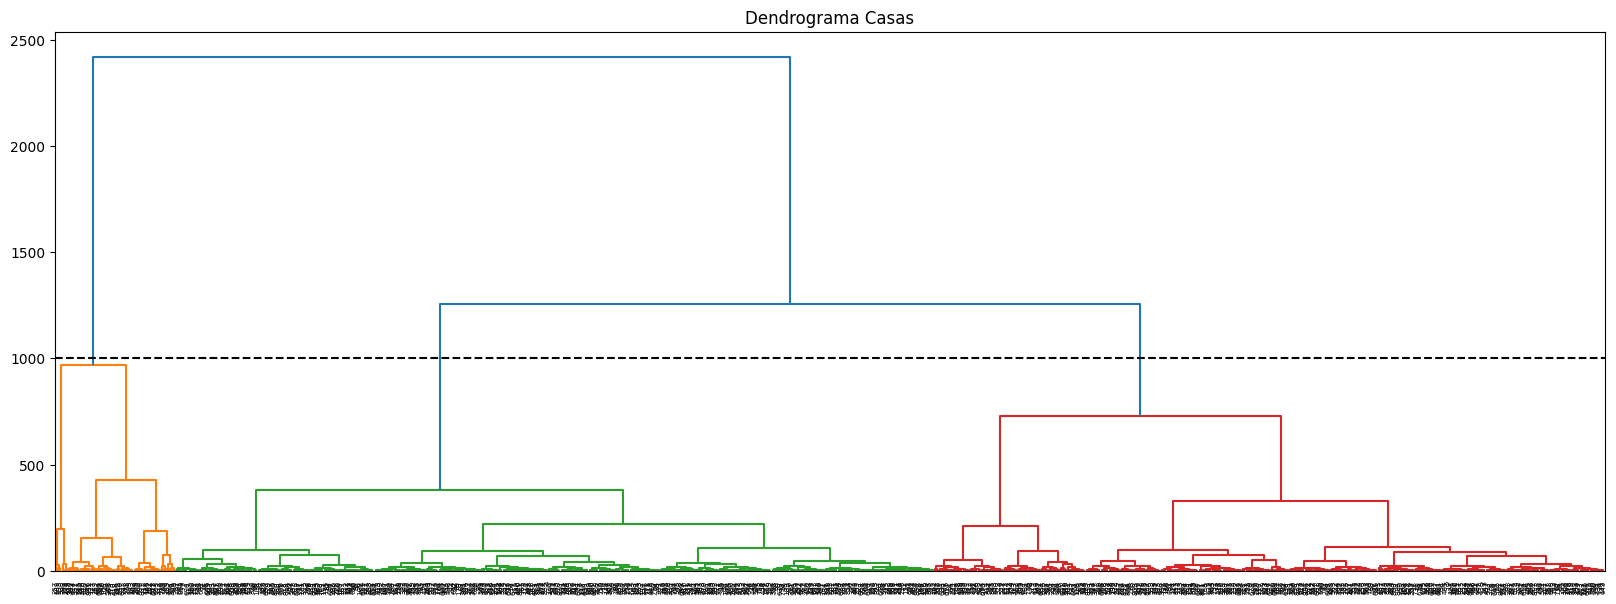

In [ ]:
dendrograma(modelo_cluster, color_threshold = 1000)
plt.title("Dendrograma Casas")
plt.axhline(y = 1000, c = 'black', linestyle = '--')
plt.show()

Calculamos el mejor valor de la silueta media.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

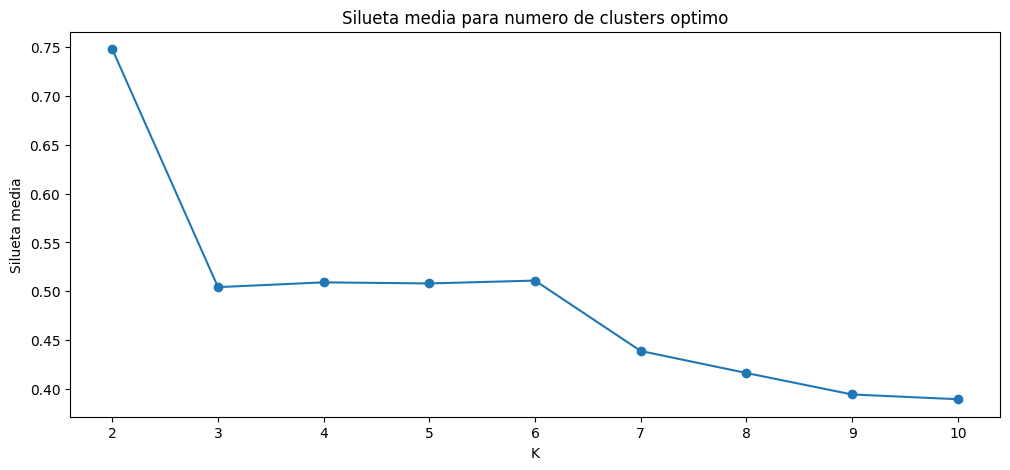

In [ ]:
silueta()

Buscamos obtener el numero de grupos k optimo de forma que se maximice el valor del coeficiente de la silueta media.

Como vemos, el valor k donde se maximiza la silueta media es k = 2, luego el modelo de clustering divide los datos en 2 grupos.

Para ver como se dividen los datos creamos un modelo de kmedias con 2 grupos o clusters.

In [ ]:
kmedias = KMeans(init = "random", random_state = 129, n_clusters = 2)
kmedias.fit(X)
clusters = kmedias.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Vemos cuantas instancias pertenecen a cada grupo.

In [ ]:
datos['ID'] = kmedias.labels_
id = datos['ID']
num_grupos = id.nunique()
for grupo in range(num_grupos):
    numero_grupo = len(id[id == grupo])
    print(f"Número de instancias en el Grupo {grupo + 1}: {numero_grupo}")

Número de instancias en el Grupo 1: 109
Número de instancias en el Grupo 2: 751


Una vez creado el modelo, representamos las caracteristicas de los grupos que ha determinado el metodo kmedias.

Primero graficamos los valores de los precios que se han determinado para cada grupo de casas.

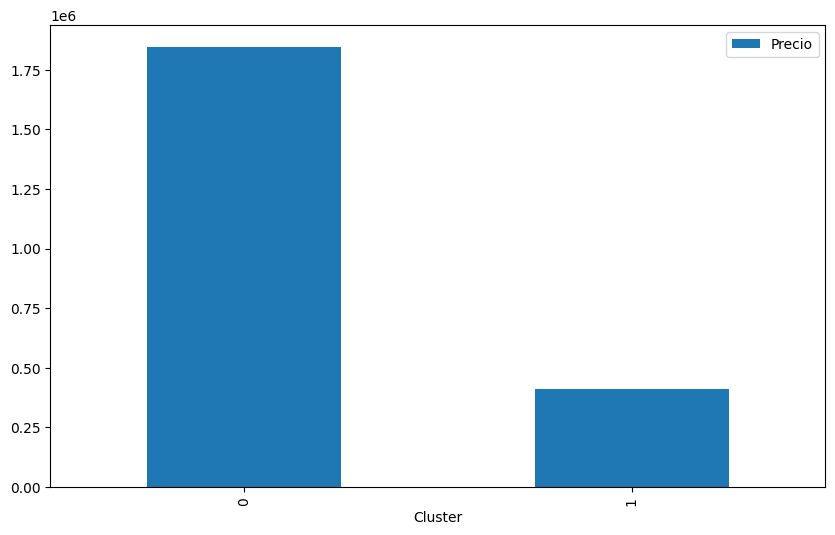

In [ ]:
datos['Cluster'] = clusters
X_precio = datos[['Precio','Cluster']]
X_precio_media = X_precio.groupby('Cluster').mean()
X_precio_media.plot(kind = 'bar', figsize = (10,6))
plt.show()

Ahora graficamos la superficie de las casas para los 2 grupos definidos.

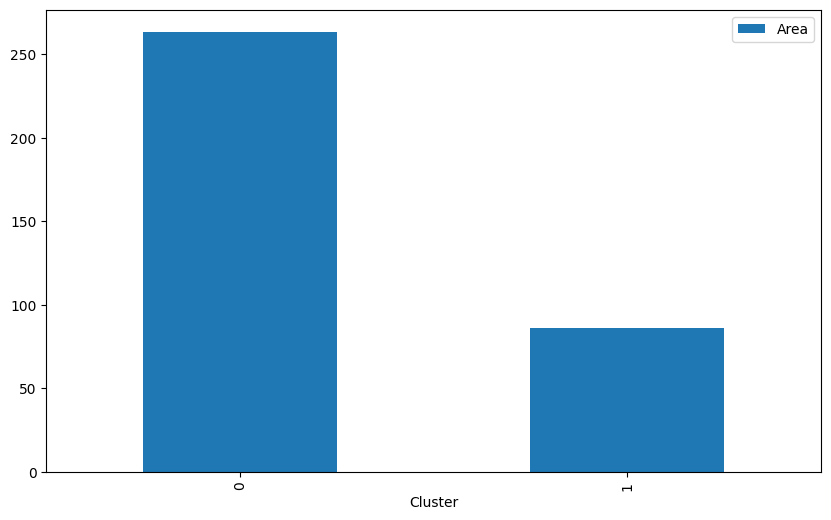

In [ ]:
X_area = datos[['Area','Cluster']]
X_area_media = X_area.groupby('Cluster').mean()
X_area_media.plot(kind = 'bar', figsize = (10,6))
plt.show()

Por ultimo, graficamos el resto de caracteristicas de la casa.

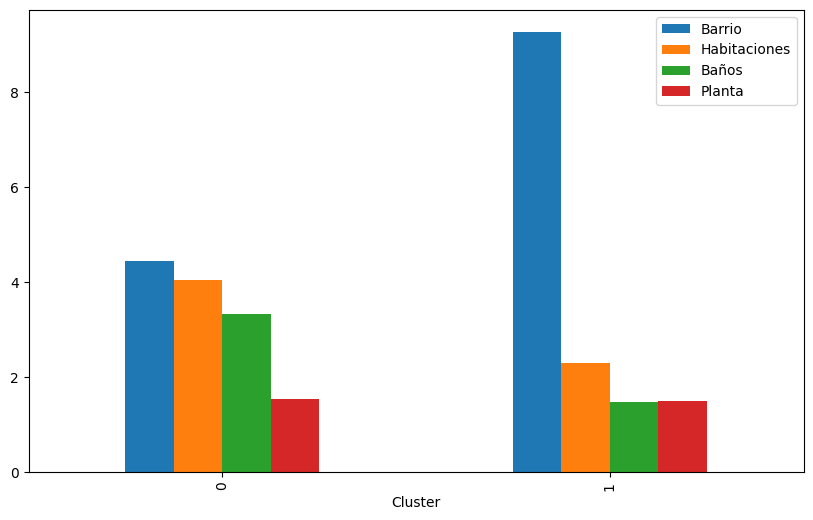

In [ ]:
X_caracteristicas = datos.drop(['ID','Precio','Area'],axis = 1)
X_caracteristicas_media = X_caracteristicas.groupby('Cluster').mean()
X_caracteristicas_media.plot(kind = 'bar', figsize = (10,6))
plt.show()

Podemos ver todas las caracteristicas medias de los 2 grupos resumidas en la siguiente tabla.

In [ ]:
Xf = datos.drop(['ID'], axis = 1)
X_medias = Xf.groupby('Cluster').mean()
X_medias

,Barrio,Habitaciones,Baños,Area,Planta,Precio
Cluster,,,,,,
0,4.440367,4.045872,3.321101,263.486239,1.541284,1.846251e+06
1,9.268975,2.286285,1.478029,86.019973,1.499334,4.110528e+05


Aunque, para el precio es de mayor informacion la mediana mas que la media pues hemos visto que hay valores atipicos que desvian la media de su verdadero valor.

In [ ]:
X_medianas = Xf.groupby('Cluster').median()
X_medianas

,Barrio,Habitaciones,Baños,Area,Planta,Precio
Cluster,,,,,,
0,4.0,4.0,3.0,238.0,0.0,1390000.0
1,8.0,2.0,1.0,81.0,0.0,288000.0


Tambien podemos ver intervalos de confianza para cada caracteristica de cada grupo.

Utilizamos intervalos de confianza basados en la distribucion normal, pues  el tamaño de cada grupo es n > 30.

In [ ]:
conf_level = 0.95
X_medias = Xf.groupby('Cluster').mean()
X_desv =  Xf.groupby('Cluster').std()

Intervalo de confianza (IC) para el primer grupo.

In [ ]:
n1 = 109
df1 = n1 - 1
se1 = X_desv.iloc[0] / np.sqrt(n1)
t_est1 = t.ppf((1 + conf_level) / 2, df1)
inf = X_medias.iloc[0] - t_est1 * se1
sup = X_medias.iloc[0] + t_est1 * se1
X_medias_f = X_medias.iloc[0].astype(float).round(2).apply(lambda x: '{:0g}'.format(x))
inf_f = inf.astype(float).round(2).apply(lambda x: '{:0g}'.format(x))
sup_f = sup.astype(float).round(2).apply(lambda x: '{:0g}'.format(x))
ic = pd.concat([X_medias_f, inf_f, sup_f], axis = 1, keys = ['Media', 'IC Inferior', 'IC Superior'])
print(ic)

                    Media  IC Inferior  IC Superior
Barrio               4.44         3.61         5.27
Habitaciones         4.05         3.84         4.25
Baños                3.32         3.09         3.55
Area               263.49       245.39       281.58
Planta               1.54         1.04         2.04
Precio        1.84625e+06  1.60434e+06  2.08816e+06


La media del barrio de las casas del primer grupo es del nivel economico de los barrios 4 o 5 que son Moncloa o Centro.

El numero medio de habitaciones es 4 y el numero medio de baños es 3.

El area media de las casas esta entre 245 y 280 metros cuadrados.

La planta media de las casas esta entre 1 y 2.

El precio medio de las casas esta entre 1.6 y 2 millones de euros, pero su mediana es 1.4 millones de euros.

Intervalo de confianza (IC) para el segundo grupo.

In [ ]:
n2 = 751
df2 = n2 - 1
se2 = X_desv.iloc[1] / np.sqrt(n2)
t_est2 = t.ppf((1 + conf_level) / 2, df2)
inf2 = X_medias.iloc[1] - t_est2 * se2
sup2 = X_medias.iloc[1] + t_est2 * se2
X_medias_f2 = X_medias.iloc[1].astype(float).round(2).apply(lambda x: '{:0g}'.format(x))
inf_f2 = inf2.astype(float).round(2).apply(lambda x: '{:0g}'.format(x))
sup_f2 = sup2.astype(float).round(2).apply(lambda x: '{:0g}'.format(x))
ic2 = pd.concat([X_medias_f2, inf_f2, sup_f2], axis = 1, keys = ['Media', 'Inferior', 'Superior'])
print(ic2)

               Media Inferior Superior
Barrio          9.27     8.83     9.71
Habitaciones    2.29     2.21     2.36
Baños           1.48     1.42     1.54
Area           86.02    83.65    88.39
Planta           1.5     1.34     1.65
Precio        411053   387764   434342


La media del barrio de las casas del primer grupo es del nivel economico de los barrios 9 o 10 que son Barajas o Ciudad Lineal.

El numero medio de habitaciones es 2 y el numero medio de baños es 1.5.

El area media de las casas esta entre 83 y 88 metros cuadrados.

La planta media de las casas esta entre 1.3 y 1.7.

El precio medio de las casas esta entre 387000 y 434000 de euros, pero su mediana es 288000 euros.